In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Step 1: Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [2]:
print(os.listdir("/kaggle/input/dogs-vs-cats"))


['test1.zip', 'train.zip', 'sampleSubmission.csv']


In [3]:
import zipfile
zip_files = ['test1','train']
for zip_file in zip_files:
    with zipfile.ZipFile(f'/kaggle/input/dogs-vs-cats/{zip_file}.zip','r') as file:
        file.extractall(".")
        print("{} unzipped successfully".format(zip_file))

test1 unzipped successfully
train unzipped successfully


In [4]:
print(os.listdir("."))

['.virtual_documents', 'train', 'test1']


# Step 2: Define constants

In [6]:
# Step 2: Define constants
IMG_SIZE = 128  # Resize images to 128x128
TRAIN_PATH = "/kaggle/input/dogs-vs-cats/train.zip"  # Path to zipped training data
TEST_PATH = "/kaggle/input/dogs-vs-cats/test1.zip"  # Path to zipped test data
SUBMISSION_PATH = "/kaggle/input/dogs-vs-cats/sampleSubmission.csv"  # Sample submission file path


# step 3: Load and Preprocess Images**
Since the training and test data are in .zip format, we’ll need to extract and process them directly. Here’s how to load the images from the zipped files.

In [7]:
import zipfile

# Function to load images and labels from zipped data
def load_images_from_zip(zip_path, img_size):
    images = []
    labels = []
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for img_name in tqdm(zip_ref.namelist()):
            if img_name.endswith('.jpg'):
                # Read and resize image
                with zip_ref.open(img_name) as img_file:
                    img = cv2.imdecode(np.frombuffer(img_file.read(), np.uint8), cv2.IMREAD_COLOR)
                    img = cv2.resize(img, (img_size, img_size))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

                    # Append image and label
                    images.append(img)
                    label = 1 if 'dog' in img_name else 0  # Label as 1 for dog, 0 for cat
                    labels.append(label)
                    
    return np.array(images), np.array(labels)

# Load training images and labels
X, y = load_images_from_zip(TRAIN_PATH, IMG_SIZE)


100%|██████████| 25001/25001 [00:28<00:00, 887.23it/s]


# Step 4: Flatten Images and Standardize Data**
Convert the images into a flat array and standardize the features for better model performance.

In [8]:
# Step 4: Flatten images and standardize data
X_flattened = X.reshape(X.shape[0], -1)  # Flatten images
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flattened)  # Standardize data


# Step 5: Dimensionality Reduction with PCA**
To reduce computational load, we’ll use PCA to keep only the most important features.

In [9]:
pca = PCA(n_components=300)  # Adjust number of components based on experimentation
X_pca = pca.fit_transform(X_scaled)

# Step 6: Split Data into Training and Validation Sets**
Split the preprocessed data into training and validation sets for model evaluation********

In [13]:

X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size=0.2, random_state=42)


# Step 7: Train the SVM model
Train an SVM classifier with an RBF kernel, which generally performs well on image classification tasks.

In [14]:
# Step 7: Train the SVM model
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)


SVC(random_state=42)

# Step 8: Evaluate the model

In [18]:

y_pred = svm_model.predict(X_val)

# Print accuracy, classification report, and confusion matrix
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))


Validation Accuracy: 0.6614
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.65      0.66      2515
           1       0.65      0.67      0.66      2485

    accuracy                           0.66      5000
   macro avg       0.66      0.66      0.66      5000
weighted avg       0.66      0.66      0.66      5000

Confusion Matrix:
 [[1632  883]
 [ 810 1675]]


In [16]:
# Import additional libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns



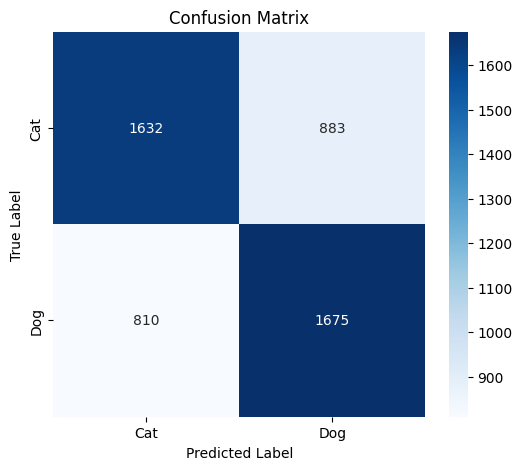

In [17]:
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix with heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Call the function to plot confusion matrix
plot_confusion_matrix(y_val, y_pred)


# Step 9: Load test images from zip for prediction

In [23]:
# Step 9: Load test images from unzipped directory for prediction
def load_test_images_from_dir(test_path, img_size):
    test_images = []
    test_image_ids = []
    
    for img_name in tqdm(os.listdir(test_path)):
        if img_name.endswith('.jpg'):
            img_path = os.path.join(test_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_size, img_size))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

            test_images.append(img)
            test_image_ids.append(int(img_name.split('.')[0]))  # Extract image ID

    return np.array(test_images), test_image_ids

# Load test images from the unzipped 'test1' directory
TEST_PATH = './test1'  # Adjusted path to the unzipped test1 folder
X_test, test_ids = load_test_images_from_dir(TEST_PATH, IMG_SIZE)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)
X_test_scaled = scaler.transform(X_test_flattened)
X_test_pca = pca.transform(X_test_scaled)


100%|██████████| 12500/12500 [00:14<00:00, 890.57it/s]


# Step 10: Predict on the test set


In [27]:
# Step 10: Predict on the test set
test_predictions = svm_model.predict(X_test_pca)

# Prepare the submission file
submission = pd.DataFrame({'id': test_ids, 'label': test_predictions})
submission = submission.sort_values(by='id')  # Sort by image ID
submission.to_csv('submission.csv', index=False)


In [28]:
# Print precision, recall, and F1 score
print("Classification Report:\n")
print(classification_report(y_val, y_pred, target_names=['Cat', 'Dog']))



Classification Report:

              precision    recall  f1-score   support

         Cat       0.67      0.65      0.66      2515
         Dog       0.65      0.67      0.66      2485

    accuracy                           0.66      5000
   macro avg       0.66      0.66      0.66      5000
weighted avg       0.66      0.66      0.66      5000



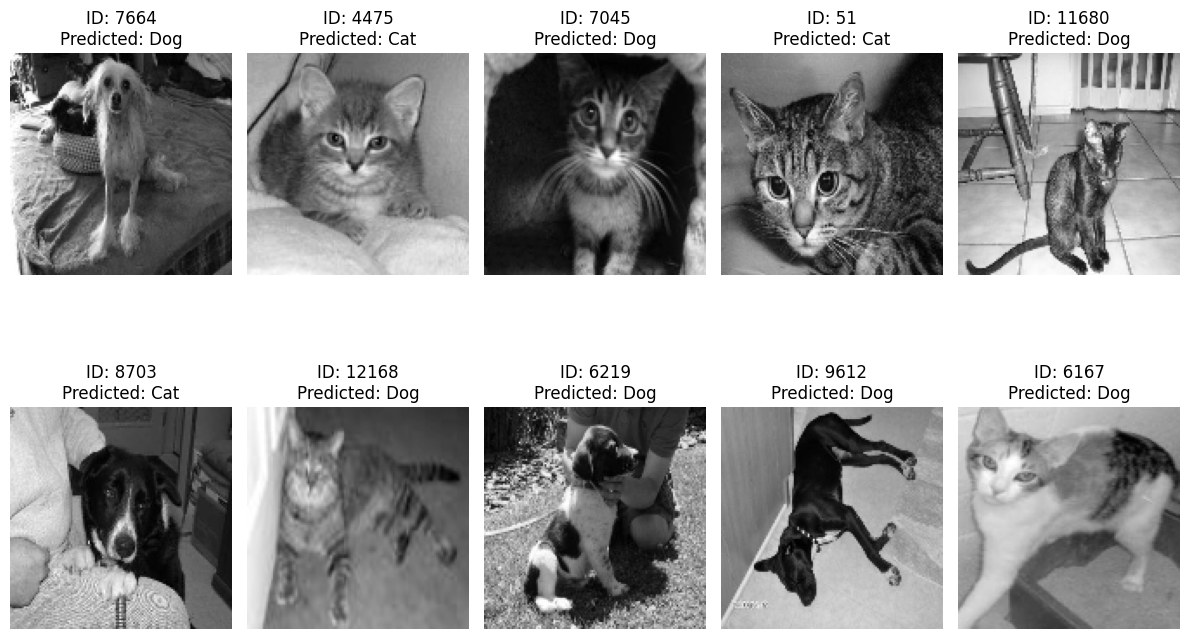

In [29]:
# Function to plot sample predictions
def plot_sample_predictions(X_test, y_pred, test_ids, num_samples=10):
    plt.figure(figsize=(12, 8))
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)
        img = X_test[i].reshape(IMG_SIZE, IMG_SIZE)  # Reshape to display as an image
        plt.imshow(img, cmap='gray')
        plt.title(f'ID: {test_ids[i]}\nPredicted: {"Dog" if y_pred[i] == 1 else "Cat"}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage with predictions on the test set
y_test_pred = svm_model.predict(X_test_pca)  # Predict on test set
plot_sample_predictions(X_test, y_test_pred, test_ids)
